In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pickle

import sys
from os.path import isfile, join
sys.path.insert(0, join(os.getcwd(),os.pardir))

from recipe_gen.pairing_utils import PairingData
from KitcheNette_master.unk_pairs_gen import getMainIngr

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\cuisine_classification"
FILES = ["cleaned_data.pkl","full_data.pkl"]

known_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","data","kitchenette_pairing_scores.csv")
unk_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","prediction_unknowns_kitchenette_pretrained.mdl.csv")
pairing_pickle = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","full_pairings.pkl")

In [4]:
df_train = pd.read_pickle(os.path.join(FOLDER_PATH, FILES[1]))
    
df_train.columns

Index(['cuisine', 'ingredients', 'all_ingredients'], dtype='object')

In [5]:
df_train["nb_ingrs"]=[len(x) for x in df_train["ingredients"]]

In [6]:
pairing = PairingData([unk_path,known_path], pickle_file=pairing_pickle, min_score=-1,trim=False)

macaroni saffron
pimento tomatillo
gelatin saffron
cool_whip saffron
watermelon saffron
cracker saffron
tea saffron
liqueur saffron
juice saffron
sprite saffron
ice saffron
extract saffron
nut saffron
teriyaki_sauce saffron
cookie saffron
banana tomatillo
stevia saffron
wafer saffron
lemonade saffron
chip saffron
syrup saffron
tequila saffron
triple_sec saffron
lobster tomatillo
penne saffron
trout saffron
muffin saffron
nori saffron
seed saffron
bun saffron
curd shrimp
phyllo_dough tomatillo
fruit saffron
barbecue_sauce saffron
cantaloupe saffron
baking_soda thousand_island_dressing
vanilla saffron
capsicum saffron
cherry saffron
oat saffron
bisquick saffron
cocoa saffron
preserve saffron
raspberry saffron
sparerib saffron
tortilla saffron
chocolate saffron
pineapple saffron
pecan saffron
candy saffron
gochujang saffron
persimmon saffron
steak saffron
broth vegetable
soup tomatillo
horseradish saffron
salmon saffron
papaya saffron
bourbon saffron
currant tomatillo
curry saffron
custar

741 pairs in total
584 pair(s) not added because of an absent ingredient in the vocab or false ingredient
rice_chex corn_chex
malt_extract irish_mos
hop irish_mos
ogo ahi
piloncillo canela
borax clementine
candlenut galangal
glitter lemongras
khoya cardamom_powder
hing toor_dal
channa_dal toor_dal
malanga yucca_root
dragee edible_glitter
glace_cherry mixed_peel
shrimp_paste candlenut
capicola sopressatum
curry toor_dal
asafoetida_powder toor_dal
ajwain black_salt
pork_butt ti
khoya ghee
mixed_peel sultana
ajwain besan
hickory_chip charcoal
french_bean ajinomoto
herbsaint rye_whiskey
ground_coriander ground_cumin
pig charcoal
mixed_spice mixed_peel
khoya saffron_strand
mixed_peel currant
kasuri_methi garam_masala_powder
gochujang dashida
mortadella sopressatum
chia_seed maca
garam_masala_powder methi
ajwain chat_masala
kitchen_twine cheesecloth
ajinomoto soya_sauce
herbsaint bitter
okra file_powder
masala toor_dal
konbu bonito_flake
kasuri_methi red_chili_powder
candied_peel currant
mat

file_powder cayenne_pepper
creme_anglaise dark_rum
green_bell_pepper achiote_oil
brinjal turmeric
fondant chocolate
dry_white_wine turbot
curry_powder raitum
blue_food_coloring cooky
peanut_oil gai_lan
ajinomoto green_chily
fresh_parsley mirliton
caper caponatum
rosemary cavolo_nero
pak_choi chili_sauce
cooky orange_gelatin
dried_thyme tasso
fish_fumet white_wine
file_powder smoked_ham
pak_choi red_pepper
cooky coffee_ice_cream
curry_powder satay_sauce
gumdrop cooky
spinach cannelloni
angel_hair_pasta tasso
sweet_chili_sauce red_curry_paste
leek dashida
yellow_onion tasso
warm_water hot_roll_mix
pappadam turmeric
crabmeat file_powder
golden_raisin panettone
beer knockwurst
sausage gumbo_file
buttermilk rennet
green file_powder
cassium ground_coriander
green_food_coloring cooky
chicken_stock squab
molass porter
shrimp tasso
dragee chocolate
ajinomoto cabbage
ground_flax_seed steel
turkey charcoal
remoulade_sauce fresh_parsley
banana bee_pollen
caster_sugar mixed_peel
celery_rib file_pow

capon cold_water
bresaola balsamic_vinegar
balsamic_vinegar wheatberry
candlenut fresh_ginger
vin_santo chicken_stock
apple crumb_topping
file_powder vegetable_oil
white_pepper file_powder
fresh_ground_pepper purslane
curry_paste fish_bone
tuna_steak white_sesame_seed
bay mirepoix
cavolo_nero bay
soy_sauce gai_lan
clove schmaltz
file_powder yellow_onion
dry_white_wine escargot
tomato_puree pretzel
tripe fish_sauce
celery_rib gumbo_file
chicken ajinomoto
ground_ginger saltpeter
skate parsley
ganache egg_white
turmeric lovage
conch potato
sweetened_whipped_cream cooky
wheat_flour steel
soy_sauce ahi
sweetbread bay
pie_plate light_brown_sugar
salt_black_pepper lovage
parsnip ketchup
pearl_barley cooked_bacon
pappadam cucumber
agave_nectar steel
celery mirliton
tomato toor_dal
soy_sauce satay_sauce
shichimi_togarashi scallion
kitchen_twine cracked_black_pepper
tomato_sauce recaito
celery quahog
satay_sauce lime_juice
ground_cinnamon crumb_topping
oil cornstarch_paste
thyme sauterne
parmesa

banana steel
red_bell_pepper tasso
fresh_thyme file_powder
onion_seed vinegar
celery squab
garlic dashida
carrot cavolo_nero
ganache whipping_cream
creme_anglaise ground_cinnamon
celery_rib duck
fresh_thyme tasso
chicken_broth schmaltz
conch celery
extra_virgin_olive_oil sopressatum
cream_cheese white_baking
baharat lemon
steel nonfat_milk
garlic_powder mirliton
baking_soda scone
oat sultana
cavolo_nero olive_oil
almond_extract mixed_peel
sweetened_condensed_milk cooky
buttermilk fondant
cooky instant_vanilla_pudding
paprika berbere
file_powder onion
ganache milk
tripe parsley
asiago_cheese gorgonzola
parmesan_rind fresh_basil
dried_oregano ground_turkey_breast
lemon crayfish
paprika gumbo_file
cooky semisweet_chocolate
sweet_red_pepper clarified_butter
pomegranate_seed watercres
kasuri_methi potato
sweetbread flour
vegetable ground_flax_seed
romesco_sauce olive_oil
dried_oregano gumbo_file
sopressatum parmesan_cheese
chili_powder dashida
romesco_sauce fresh_ground_black_pepper
tomato 

pie_plate fresh_lemon_juice
gremolatum kosher_salt
kosher_salt scone
fish_fumet unsalted_butter
fresh_sage tabasco_sauce
pepper knockwurst
squid crushed_red_pepper_flake
sweetbread fresh_ground_black_pepper
apple mixed_peel
smoked_bacon pepper
berry cooky
mussel kosher_salt
tatsoi vegetable_oil
salt_black_pepper file_powder
kitchen_twine fresh_ground_black_pepper
garlic_clove purslane
cooky unflavored_gelatin
pluot unsalted_butter
pitted_date wheat_flour
purslane olive_oil
tlefish olive_oil
parsley sauterne
vegetable_oil gumbo_file
dry_mustard tasso
tomato ahi
sweetened_flaked_coconut cooky
dry_sherry minced_garlic_clove
lemon_juice daikon_sprout
tripe cayenne_pepper
ginger smy_cream
squirrel salt_pepper
salsify celery
ground_nutmeg steel
cooky red_food_coloring
pomegranate_seed golden_raisin
kosher_salt caperberry
parmesan_rind kosher_salt
green zucchini
ketchup charcoal
unsweetened_chocolate cooky
chicken_breast cremini_mushroom
vin_santo extra_virgin_olive_oil
spinach black_bean_pas

rom salt_pepper
unsalted_butter caster
tequila yellow_bell_pepper
cooky powdered_sugar
worcestershire_sauce charcoal
black_pepper duckling
pigeon vegetable_oil
butter sauterne
crushed_tomato marshmallow
spaghetti_sauce_mix water
ground_cumin charcoal
conch garlic_powder
conch extra_virgin_olive_oil
black_pepper berbere
candied_peel granulated_sugar
onion knockwurst
white_rice paprika
rennet milk
garlic ajwain
creme_fraiche asparagus
celery sauterne
brown_rice orange
egg caster
pea_carrot celery
rye_berry olive_oil
dried_cranberry canola_oil
carrot mirepoix
carrot acorn
sweetbread salt_pepper
black_pepper salsify
cinnamon chocolate_wafer_cookie
hot_water steel
ajwain salt
skate olive_oil
bisto water
candlenut water
file_powder ground_cumin
cooking_spray sourdough_bread
extra_virgin_olive_oil canned_tomato
poultry onion
canela water
seasoning basil
salt_black_pepper kaffir_lime
black_pepper cannelloni
squirrel water
file_powder dry_mustard
sesame_paste fresh_ginger
mirliton unsalted_butt

orange_sauce salt
onion glace_de_viande
hot_pepper ground_coriander
onion chipotle_paste
egg orange_sauce
ziti_pasta garlic_powder
scone salt
satay_sauce onion
baking_soda steel
sweet_onion ground_beef
conch milk
butter rockfish
kitchen_twine ground_black_pepper
skate onion
cassium onion
instant_yeast confectioner's_sugar
water wheatberry
olive_oil charcoal
onion_seed water
cocoa_powder steel
spelt baking_powder
onion soy_chorizo
onion culantro
double_crust milk
creme_anglaise baking_powder
bacon file_powder
duckling salt_pepper
garlic_clove conch
amchur salt
apple brown_sugar
heirloom_tomato shrimp
toasted_sesame_oil smoked_salmon
raitum salt
cinnamon pie_plate
malt_vinegar barbecue_sauce
hot_pepper_sauce velveetum_cheese
maca water
water culantro
cherry_tomato rice_wine_vinegar
gourd salt
peanut_butter cooky
cilantro gingerroot
green_pepper red_wine_vinegar
malanga onion
garlic_clove tripe
tomato schmaltz
kitchen_twine paprika
egg abalone
teriyaki_marinade vegetable_oil
caciocavallo 

oil monterey_jack_cheese
cooky cocoa
caciocavallo water
butter squirrel
chili bell_pepper
poultry salt
green_bell_pepper corned_beef
raspberry_couli butter
purslane water
mixed_peel vanilla_extract
fresh_basil white_onion
sherry_wine_vinegar beef_broth
dijon_mustard garlic
fresh_oregano granulated_garlic
egg perch
sweetbread olive_oil
yogurt yellow_onion
chimichurri_sauce salt
dried_parsley butternut_squash
tlefish salt
turbot salt
garlic_clove flaked_sea_salt
pak_choi water
dragee butter
broccoli cucumber
fresh_parsley crabmeat
chicken_broth pure_olive_oil
butter fondant
conch olive_oil
vin_santo flour
lime nonstick_cooking_spray
squab salt
capon butter
chinese_five_spice_powder salt_black_pepper
fresh_basil granulated_garlic
salt achiote_oil
salt verjuice
lettuce dried_dill_weed
cooky pecan
water schmaltz
coriander cooked_chicken
egg nopale
olive_oil culantro
light_soy_sauce apple_cider_vinegar
date shallot
lemon_juice lemon_juice
broccoli chili_paste
poultry flour
salsify salt
mixed

sugar tomato
hot_sauce egg_white
white_wine_vinegar fresh_orange_juice
sugar poultry
mild_cheddar_cheese sea_salt
lime sherry_wine
onion charcoal
file_powder unsalted_butter
peanut_butter dried_basil
treacle olive_oil
lemon cooky
crema brown_sugar
eggplant sausage
green_pepper spinach
egg spelt
butter swordfish
onion_powder hot_sauce
carrot fresh_ground_black_pepper
cinnamon breadcrumb
sugar charcoal
choy_sum salt
hot_pepper_sauce whipping_cream
lemon_juice turkey
shredded_cheddar_cheese fontina_cheese
carrot steel
sugar berbere
file_powder olive_oil
milk french_bread
butter file_powder
pak_choi salt
dijon_mustard egg_substitute
mini_marshmallow orange_juice
onion_powder white_sugar
basil pork_tenderloin
walnut hot_water
salt hot_roll_mix
tripe butter
lemon_thyme vegetable_oil
cooky ground_nutmeg
egg egg
sugar spelt
onion_salt fresh_ground_black_pepper
cooky orange_juice
steel fresh_ground_black_pepper
cinnamon honey
orange_zest celery_rib
fresh_lemon_juice margarine
fresh_ground_peppe

In [7]:
len(pairing)

822

In [8]:
VOCAB_PATH = os.path.join(os.getcwd(),os.pardir,"recipe_1m_analysis", "data") 
with open(os.path.join(VOCAB_PATH, "recipe1m_vocab_ingrs.pkl"), 'rb') as f:
        vocab_ingrs = pickle.load(f)
        
vocab_main_ingr = getMainIngr(vocab_ingrs)
print(len(vocab_main_ingr),len(vocab_ingrs))


-_-
stock
994 1000


In [9]:
vocab_ingrs.delete_word("tawny_port")

In [10]:
vocab_main_ingr.word2idx["tawny_port"]

803

In [11]:
"tawny_port" in pairing.pairedIngr

False

In [12]:
to_add = []
count_err = 0
for index, recipe in df_train.iterrows():
    score = 0
    nb=0
    for i,ingr1 in enumerate(recipe["ingredients"]):
        for ingr2 in recipe["ingredients"][i+1:]:
            try:
                score += pairing.pairing_scores[pairing.pairedIngr[ingr1]][pairing.pairedIngr[ingr2]]
                nb+=1
                
            except KeyError:
                pass

    try:
        to_add.append(score/nb)
    except ZeroDivisionError:
        to_add.append(0)
        
df_train["recipe_score"] = to_add
print(count_err)

0


In [13]:
df_train["recipe_score"].mean()  

-0.10828336841706251

In [14]:
df_train[["cuisine","recipe_score"]][df_train["recipe_score"]!=0].groupby(["cuisine"]).mean().sort_values(by="recipe_score")

,recipe_score
cuisine,
SouthernEuropean,-0.131157
WesternEuropean,-0.119182
Asian,-0.115698
LatinAmerican,-0.114821
NorthAmerican,-0.114424
EasternEuropean,-0.111678
SoutheastAsian,-0.108840
NorthernEuropean,-0.101696
MiddleEastern,-0.096388


Text(0, 0.5, 'Proportion of the cuisine(%)')

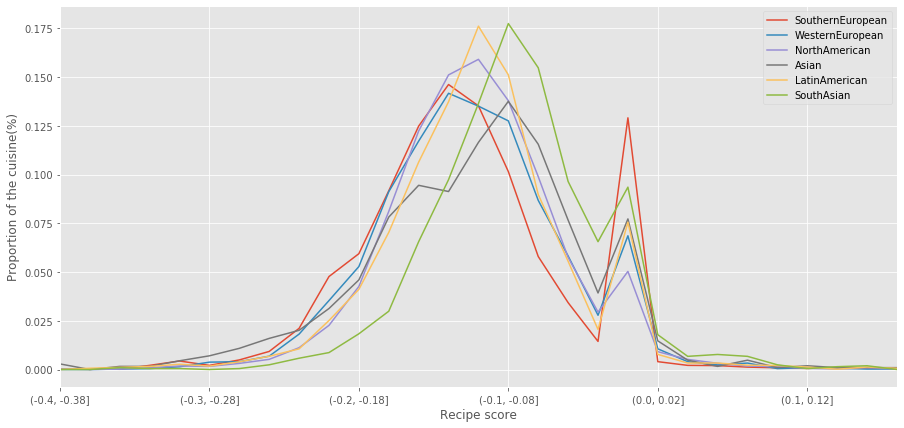

In [15]:
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[:6]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")

Text(0, 0.5, 'Proportion of the cuisine(%)')

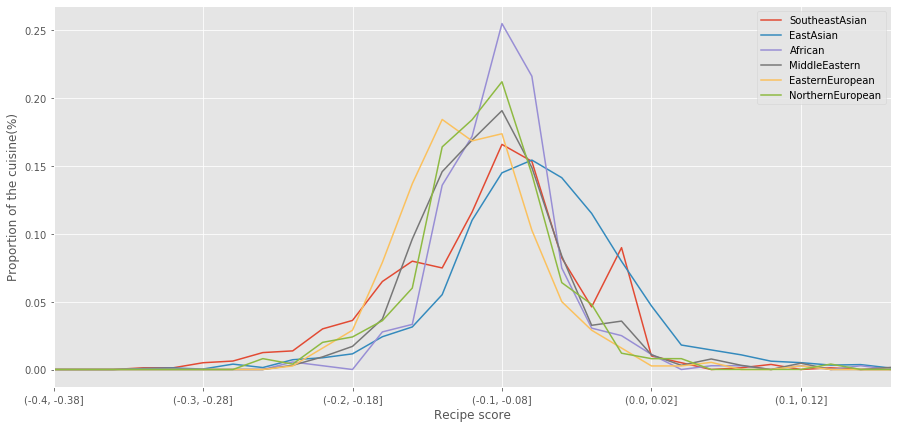

In [16]:
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[6:]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")

In [17]:
df_train[(df_train["recipe_score"]==0) & (df_train["nb_ingrs"]>1)].groupby(["cuisine"]).count()

,ingredients,all_ingredients,nb_ingrs,recipe_score
cuisine,,,,
African,1,1,1,1
Asian,169,169,169,169
EastAsian,35,35,35,35
EasternEuropean,1,1,1,1
LatinAmerican,406,406,406,406
NorthAmerican,1606,1606,1606,1606
SouthAsian,119,119,119,119
SoutheastAsian,59,59,59,59
SouthernEuropean,1059,1059,1059,1059


In [18]:
len(df_train)

84029